In [1]:
import cv2
import random
import json
import time

import torch
import numpy as np
from tqdm import tqdm

import clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide 

from PIL import Image  
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from sam_caf import hyper_params_tuning, get_crops, retrieve_relevant_crop, retrieve_relevant_crop_biomed, get_sam_prompts, sam_predicton, retrieve_relevant_crop_biomed_topk

In [2]:
#config
class DictToObject:
    def __init__(self, dict_obj):
        for key, value in dict_obj.items():
            setattr(self, key, value)

config_dict = {
    "model_name" : "SAM",
    "model_type" : "vit_h",
    "source":    "False", 
    "refine" : "False",
    "pre_trained": "True", 
    "sam_ckpt":  "/data/aofei/LLM/SAM/sam_vit_h_4b8939.pth", 
    "clip_prompts": "./clip_prompts/abd_seg.json"
}

config = DictToObject(config_dict)

prompt_mode, mode = "crops", "sam_clip"

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    return image

In [3]:
import os
# os.environ["TRANSFORMERS_CACHE"]="/data/aofei/huggingface_cache/transformers"
os.environ["HF_HOME"]="/data/aofei/huggingface_cache/transformers"
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

biomed_clip_model, biomed_preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224', device="cuda")
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

clip_model, preprocess = clip.load("ViT-L/14", device="cuda")
sam_checkpoint = config.sam_ckpt

sam = sam_model_registry[config.model_type](checkpoint=sam_checkpoint)
sam.to("cuda")
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

dice_scores = []
mask_generator, area = hyper_params_tuning(sam)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.

In [4]:
def sam_generation(image_path):
    image = preprocess_image(image_path=image_path)
    with torch.no_grad():
        # if mode == "sam_clip":
        masks = mask_generator.generate(image)
        masks = [mask for mask in masks if mask["area"] < area] # area filtering based on area value from hyper-params tuning
        img_crops = get_crops(image, masks, prompt_mode)
        
    return masks, img_crops

def filter_sam_results(masks, img_crops):
    new_masks, new_img_crops = [], []
    for i in range(len(masks)):
        mask = masks[i]
        if mask['bbox'][0] == 0 or mask['bbox'][1] == 0:
            continue
        if mask['bbox'][2] <= 12 or mask['bbox'][3] <= 12:
            continue
        y_max, x_max = mask['bbox'][1] + mask['bbox'][3], mask['bbox'][0] + mask['bbox'][2]
        if y_max > 253 or x_max > 253:
            continue
        new_masks.append(mask)
        new_img_crops.append(img_crops[i])
    return new_masks, new_img_crops

def get_topk_similar(k, crop_scores):
    sorted_scores = sorted([(i, m) for (i,m) in enumerate(crop_scores)], key=lambda x: x[1], reverse=True)
    return sorted_scores[:k]

def get_compelete_contour(masks):
    width_list = []
    # need to consider the chest xray
    for i in masks:
        width, height = i['bbox'][2], i['bbox'][3]
        width_list.append(width)
    sorted_width = sorted([(i, m) for (i,m) in  enumerate(width_list)], key=lambda x: x[1], reverse=True)
    return sorted_width[0][1]

def judge_inner_boxes(bboxes):
    for bbox in bboxes:
        bbox

In [30]:
masks_image_dict = dict()
masks_all_image_dict = dict()
crops_image_dict = dict()
def generate_segments(query, image_path):
    if masks_image_dict.__contains__(image_path):
        masks = masks_image_dict[image_path]
        img_crops = crops_image_dict[image_path]
    else:
        masks, img_crops = sam_generation(image_path=image_path)
        masks, img_crops = filter_sam_results(masks, img_crops)
        masks_image_dict[image_path] = masks
        crops_image_dict[image_path] = img_crops
    img_crops_filtered = img_crops
    prompts = {"query": [query]}
    max_indices, scores = retrieve_relevant_crop_biomed_topk(img_crops, prompts, biomed_clip_model, biomed_preprocess, config, tokenizer=tokenizer, topk=20)
    # topk_indices = get_topk_similar(3, scores["query"])
    # define a set of rules, firstly return top3
    # if there is no explicit organs to be used as query, then just use the whole segmentation
    # if the smaller boxes are in the bigger box, then use all of them but assign higher weights on smaller inner boxes
    bboxes = []
    segs = []
    # print(max_indices)
    if max_indices is not None:
        for i in max_indices["query"]:
            bboxes.append(masks[i]["bbox"])
            segs.append(masks[i]["segmentation"])
        return bboxes, segs, max_indices["query"]
    else:
        return bboxes, segs, []


def generate_all_segments(image_path):
    if masks_all_image_dict.__contains__(image_path):
        masks = masks_all_image_dict[image_path]
    else:
        masks, img_crops = sam_generation(image_path=image_path)
        masks, img_crops = filter_sam_results(masks, img_crops)
        masks_all_image_dict[image_path] = masks
    return masks

In [50]:

# image_path = "/data/aofei/hallucination/Slake/imgs/xmlab49/source.jpg"
image_path = "/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med/visualize/images/example1.jpg"
# question = "Does the picture contain liver?"
question = "Where is the spleen located?"
# question = "Does the image show any signs of liver cancer?"

query = question


# bbox, segs, max_indices = [], [], []
bbox, segs, max_indices = generate_segments(query, image_path)
# print(bbox
    

In [51]:
max_indices

[11, 4, 14, 16, 15, 12, 9, 2, 10, 7, 6, 3, 18, 17, 8, 5, 0, 1, 13]

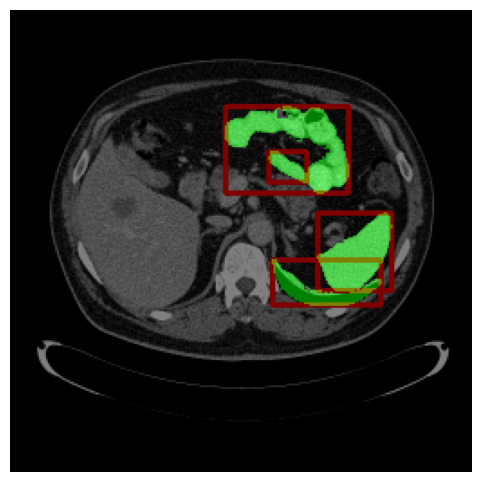

In [59]:
visualize_with_indices(image_name=image_path, indices_list=[15,12, 0,1])

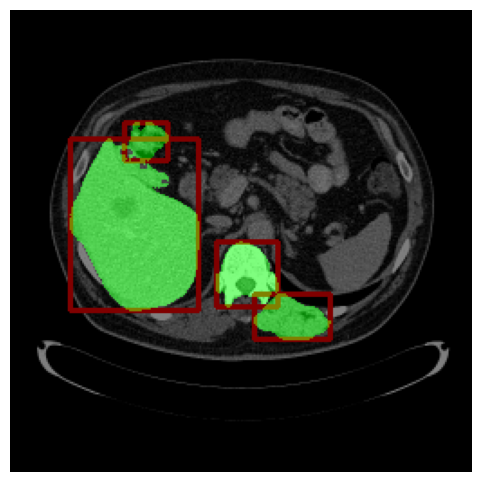

: 

In [ ]:
visualize_with_indices(image_name=image_path, indices_list=[10, 14, 16,  5])

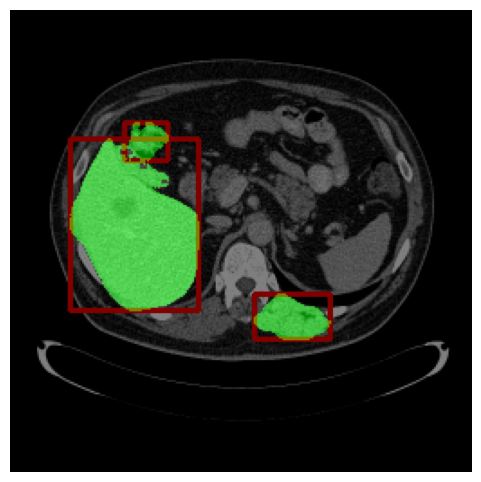

In [13]:
visualize_with_indices(image_name=image_path, indices_list=max_indices[:3])

In [18]:

image_path = "/data/aofei/hallucination/Slake/imgs/xmlab224/source.jpg"
# question = "What is the organ on the lower right corner of the body in this image"
question = "image of abodomen CT, liver spleen"

query = question

# bbox, segs, max_indices = [], [], []
bbox, segs, max_indices = generate_segments(query, image_path)

In [28]:

image_path = "/data/aofei/hallucination/Slake/imgs/xmlab185/source.jpg"
# question = "What is the organ on the lower right corner of the body in this image"
question = "What diseases are included in the picture? Image of Chest X-ray lungs"

query = question

# bbox, segs, max_indices = [], [], []
bbox, segs, max_indices = generate_segments(query, image_path)

In [19]:
max_indices

[7, 11, 12, 9]

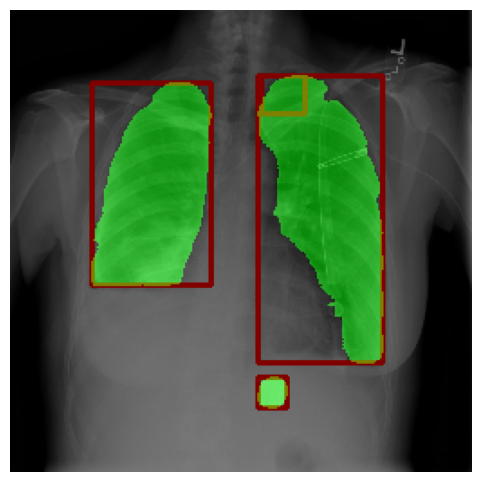

In [31]:
visualize_with_indices(image_name=image_path, indices_list=max_indices)

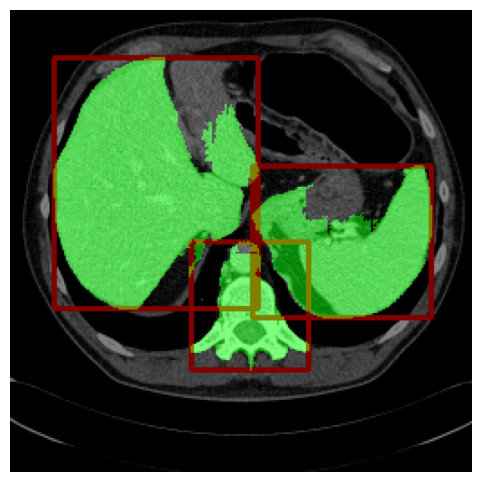

In [27]:
visualize_with_indices(image_name=image_path, indices_list=[7, 12, 9])

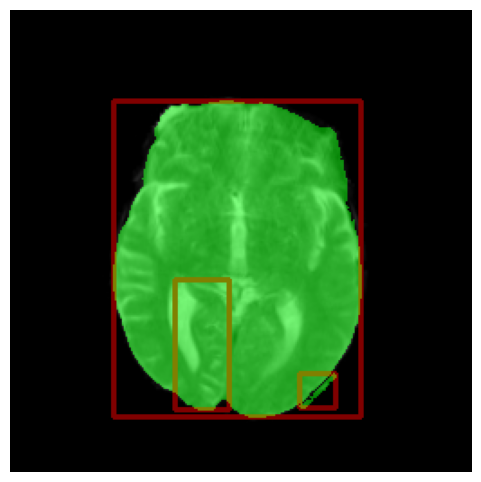

In [12]:
visualize_with_indices(image_name=image_path, indices_list=max_indices)

In [ ]:
# visualize_with_indices(image_name='synpic28602.jpg', indices_list=[3, 8, 9], fig_width=5)

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_with_indices(image_name, indices_list:list = None, indices:tuple = None, width_threshold=260, fig_width=6):
    # image_path = os.path.join("/data/aofei/hallucination/OmniMedVQA/VQA/raw/OmniMedVQA", image_name)
    image_path = image_name
    masks = masks_image_dict[image_path]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_boxes = image_rgb.copy()

    # Create an empty mask with the same size as the image
    combined_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Loop over all segmentation results
    selected_masks = []
    if indices is not None:
        selected_masks = masks[indices[0]:indices[1]]
    elif indices_list is not None:
        for i in indices_list:
            selected_masks.append(masks[i])

    for seg in selected_masks:
        # Unpack bbox (bounding box)
        x, y, w, h = seg['bbox']
        if w >= width_threshold:
            continue

        # Draw the bounding box (in red)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract and resize the segmentation mask
        mask = seg['segmentation'].astype(np.uint8)
        mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))  # Resize to fit the image

        # Add mask to combined mask (use a different color for each mask if desired)
        color_mask = np.zeros_like(image_rgb)
        color_mask[mask == 1] = [0, 255, 0]  # Green mask for the segment
        combined_mask = np.maximum(combined_mask, color_mask)

    # Blend the original image with the combined mask once
    alpha = 0.5  # Transparency factor
    image_with_masks = cv2.addWeighted(image_with_boxes, 1 - alpha, combined_mask, alpha, 0)

    # Display the image with bounding boxes and masks
    plt.figure(figsize=(fig_width, fig_width))
    plt.imshow(image_with_masks)
    plt.axis('off')  # Turn off axis for clean visualization
    plt.show()